In [1]:
import os
import re
import json
import copy
import itertools
import warnings
import numpy as np
from time import time
from pprint import pprint
import pandas as pd
from pandas.io.formats.style import Styler
import nltk # version 3.2.5
from nltk.corpus import stopwords
from wordcloud import WordCloud # version 1.3.1

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
sns.set(style="whitegrid")
sns.set(font_scale=1.2)
%matplotlib inline

warnings.filterwarnings('ignore')
nltk.download('stopwords');

WORKING_DIR = os.getcwd()
DATA_PATH = os.path.join(WORKING_DIR, 'data', 'lalonde.csv')

[nltk_data] Downloading package stopwords to /Users/lia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

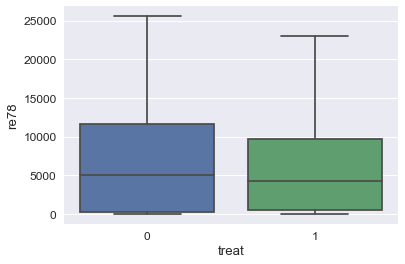

In [2]:
lalonde = pd.read_csv(DATA_PATH)
sns.boxplot(x='treat', y='re78', data=lalonde, showfliers=False)

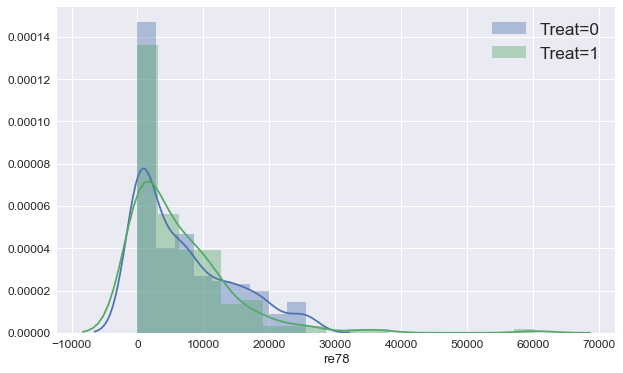

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
c = sns.distplot(lalonde[lalonde.treat==0]['re78']);
c = sns.distplot(lalonde[lalonde.treat==1]['re78']);
c.legend(['Treat=0', 'Treat=1'], loc='best', fontsize='xx-large');

If this is a real experiment as a research I would say that there the treatment don't affect the outcome. 

### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [3]:
# TODO

### 3. A propsensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [4]:
# TODO

### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [5]:
# TODO

### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

In [6]:
# TODO

### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [7]:
# TODO

# Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

### Split ***{validation, test}*** assumptions
`20newsgroup` dataset is available in `sklearn` library and it is split already into `train` and `test` set so we will use this split instead of the proposed in the exercise because it is consistency and can be compared with others benchmarks and it is possible have more data to train the model.
The `test` set in about 40% of the entire dataset and it will be split randomly into 2 datasets in the same proportion, half as our real `test` and the other half to `validation`. 

As we will be using `Random Forest Classifier` as our model, we could also use the out-of-bag to evaluate our model.

In [8]:
ng_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=234, remove=('headers', 'footers', 'quotes'))
ng_all_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=891, remove=('headers', 'footers', 'quotes'))

In [9]:
def select_validation_test(data, seed):
    len_data = len(data['data'])
    np.random.seed(seed)
    
    idxs_validation  = np.random.choice(len_data, len_data/2, replace=False)
    idxs_test = np.array(list(set(range(len_data)) - set(idxs_validation)))
    
    return [{'data': [data['data'][i] for i in idxs_validation],
             'target': [data['target'][i] for i in idxs_validation], 
             'target_names': data['target_names']}, 
            {'data': [data['data'][i] for i in idxs_test],
             'target': [data['target'][i] for i in idxs_test],
             'target_names': data['target_names']}]

ng_validation, ng_test = select_validation_test(ng_all_test, 9823)

In [10]:
n_total = len(ng_train['data']) + len(ng_validation['data']) + len(ng_test['data'])
print('Observations in train: {train} ({p_train}%) \nObservations in valid: {validation}  ({p_validation}%)\nObservations in test:  {test}  ({p_test}%)'
      .format(train=len(ng_train['data']), 
              p_train=round(len(ng_train['data'])*100 / n_total, 0),
              validation=len(ng_validation['data']),
              p_validation=round(len(ng_validation['data'])*100 / n_total, 0),
              test=len(ng_test['data']),
              p_test=round(len(ng_test['data'])*100 / n_total, 0)))

Observations in train: 11314 (60.0%) 
Observations in valid: 3766  (20.0%)
Observations in test:  3766  (20.0%)


### Data Analysis
In order to analyse and makes sense of the data the following treatments will be applied:
1. Put all words as lower case because it can distorce the frequency values
2. Remove numbers
3. Extract just the words, it means, remove all {`!`, `\n`, ..., `?`}
1. Remove the `stop words` from the texts because those words don't contain relevent importance for each subject and are very frequent, so it might distorce and mitigate the value of the words that real matter and is able to identify each subject. Below we can see example of english stop words defined by the library `ntk`:

In [11]:
stopwords.words('english')[1:10]

['me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

In [12]:
def treat_text(text):
    """Returns a text with just raw words, without stop words and in lower case"""
    stops = stopwords.words('english')
    text = text.lower()
    list_words = re.findall(r"[\w']+", text)
    filtered = filter(lambda x: ((x not in stops) & (x.isalpha())), list_words)
    
    return ' '.join(filtered)

In [13]:
treated_train_data = list(map(treat_text, ng_train['data']))
treated_validation_data = list(map(treat_text, ng_validation['data']))
treated_test_data = list(map(treat_text, ng_test['data']))

Now we can do a word count by category

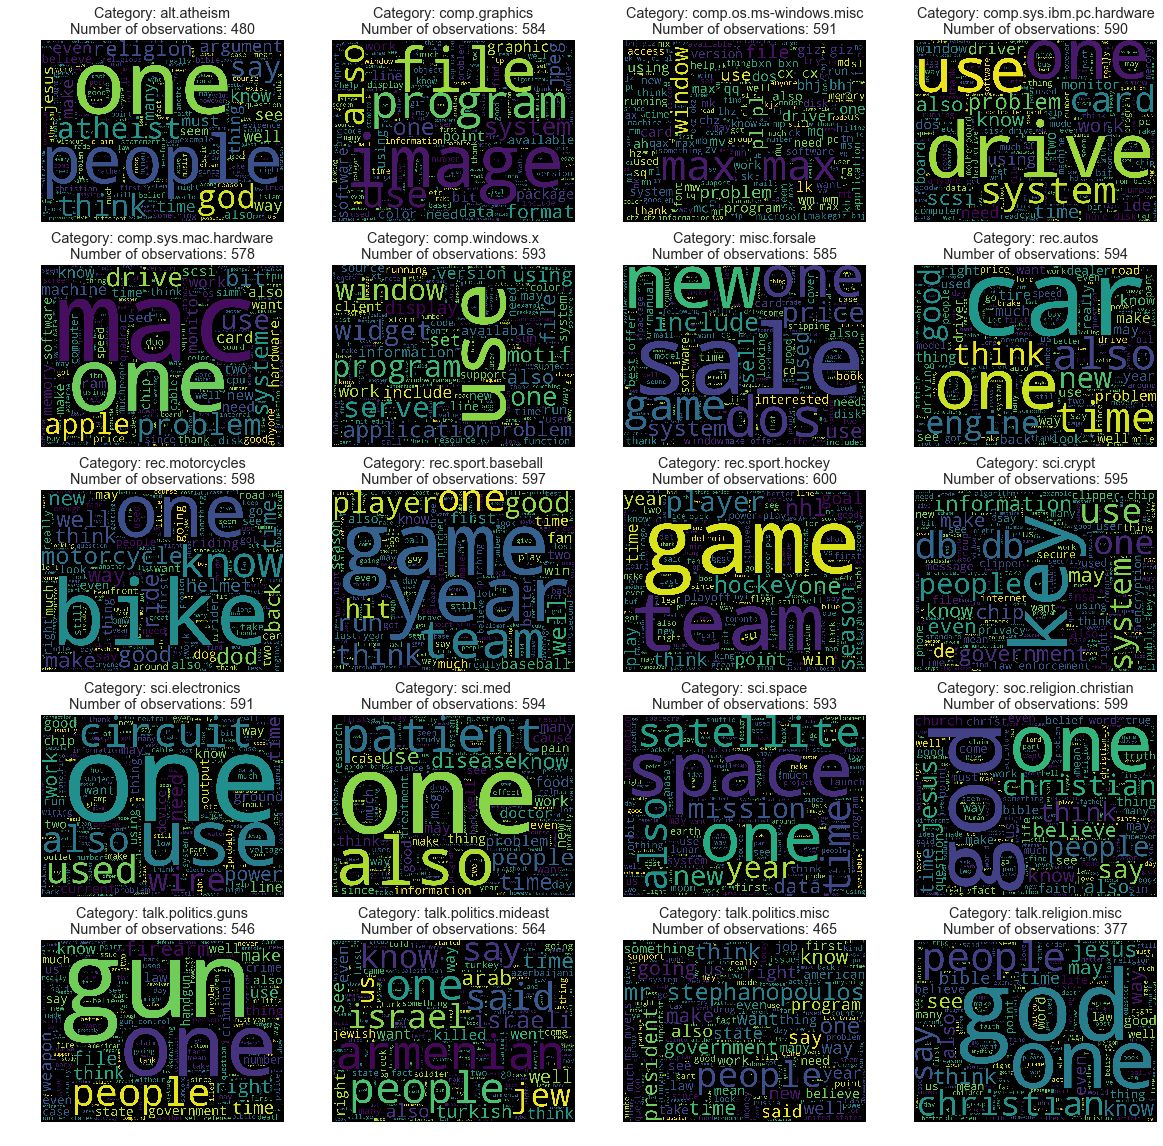

In [14]:
f, ax = plt.subplots(5, 4, figsize=(20, 20))
positions = np.array(range(20)).reshape(5, 4)
for num_c, c in enumerate(ng_train['target_names']):
    pos = np.where(positions==num_c)
    
    idxs_category = [i for i,val in enumerate(ng_train['target']) if val==num_c]
    texts_category = [treated_train_data[i] for i in idxs_category]
    
    cloud = WordCloud(width=1440, height=1080).generate(' '.join(texts_category));
    ax[pos[0][0], pos[1][0]].imshow(cloud);
    ax[pos[0][0], pos[1][0]].set_title('Category: {c}\nNumber of observations: {n}'.format(c=c, n=len(texts_category)))
    ax[pos[0][0], pos[1][0]].axis('off')

In the images above it clear which categories will be easier to identify for any model that we run. 

For instance, the weight of the word `gun` in the category `talk.politics.guns` is very high and there is no other category with the same word in evidence. 

However the categories {`soc.religion.christian`, `talk.religion.misc`} will perform worst because they are very close and the words {`good`, `one`, `people`} are very relevant in both categories.

The word `one` also appears in many categories, it might be considerer a stop word too.

### TF-IDF
For tf-idf analysis, we will keep with the same treatment of the last section. The `sklearn` can also apply the treatment if it is especified in the parameters.

For the word $i$ in the observation $j$, the weight $w_{ij}$ given by:

$$
w_{ij} = tf_{ij} \times log \bigg (\frac{N}{df_i} \bigg)
$$

where $t_{ij}$ is the number of occurrences of $i$ in $j$, $df_{i}$ is the number of observations containing $i$ and $N$ is the number of observations.

Intuitively, it is a metric that gives the importance of one word in one text in relation all the texts analysed.

** To avoid data snooping and then possible overfitting in the model, the `tf-idf` will be calculated just using the train dataset, not with the entire dataset as suggested in the task **


### Default Random Forest Model

The confusion matrix is a little overwhelming for a large number of categories and the absolute values are not interpretable, so each line will be divided by the number of observations in each category.

In [15]:
clf = Pipeline([('tfidf_vectorizer', TfidfVectorizer(lowercase=True)),
                ('rf_classifier', RandomForestClassifier())])

clf.fit(treated_train_data, ng_train['target']);

In [32]:
confusion = pd.DataFrame(confusion_matrix(ng_validation['target'], clf.predict(treated_validation_data)), columns=ng_validation['target_names'])
confusion['category'] = ng_train['target_names']
confusion = confusion.set_index('category')

for i, c in enumerate(confusion.columns):
    confusion[c] = confusion[c] / sum([e==1 for e in ng_validation['target']])

def highlight(x):
    colors = ['color: pink']*len(x)
    green_position = list(x.index).index(x.name)
    colors[green_position] = 'color: green'
    return colors

confusion = confusion.applymap(lambda x: round(x, 3))
HTML(Styler.render(confusion.style.apply(highlight)))

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
category,,,,,,,,,,,,,,,,,,,,
alt.atheism,0.293,0.011,0.006,0,0.029,0,0.017,0.063,0.029,0.023,0.017,0.034,0.006,0.034,0.052,0.224,0.029,0.011,0.017,0.017
comp.graphics,0.006,0.529,0.086,0.057,0.063,0.098,0.017,0.017,0.023,0.017,0.006,0.011,0.011,0.011,0.034,0.006,0.006,0,0,0
comp.os.ms-windows.misc,0.023,0.098,0.58,0.069,0.075,0.069,0,0.04,0.023,0.011,0.006,0,0.011,0.011,0.023,0.006,0.006,0.011,0.011,0
comp.sys.ibm.pc.hardware,0,0.109,0.172,0.523,0.144,0.04,0.052,0.052,0.011,0.011,0.011,0.029,0.04,0,0.011,0,0,0.006,0.006,0
comp.sys.mac.hardware,0,0.063,0.046,0.144,0.615,0.023,0.034,0.08,0.011,0.011,0.006,0,0.023,0.006,0.006,0.006,0,0,0,0.006
comp.windows.x,0.023,0.155,0.201,0.011,0.029,0.569,0.011,0.029,0,0,0.023,0,0.011,0,0.023,0.006,0.006,0,0,0
misc.forsale,0,0.023,0.029,0.092,0.04,0.017,0.741,0.075,0.011,0.034,0.006,0,0.017,0.006,0.006,0.006,0.011,0.006,0.017,0
rec.autos,0,0.023,0.011,0.046,0.057,0.023,0.034,0.741,0.08,0.011,0.011,0,0.046,0.006,0.011,0.006,0.017,0.011,0.017,0.006
rec.motorcycles,0.011,0.011,0.029,0.029,0.029,0.006,0.04,0.161,0.73,0.046,0.006,0.011,0.023,0.011,0.023,0.023,0.017,0.011,0.006,0.011


% of correct for each category

In [33]:
HTML((pd.DataFrame(np.diag(confusion), index=confusion.columns, columns=['% Correct Classification'])
      .sort_values('% Correct Classification', ascending=False)).to_html())

,% Correct Classification
rec.sport.hockey,0.793
soc.religion.christian,0.770
misc.forsale,0.741
rec.autos,0.741
rec.motorcycles,0.730
rec.sport.baseball,0.718
sci.space,0.678
sci.crypt,0.655
talk.politics.mideast,0.638
comp.sys.mac.hardware,0.615


A funny fact is that we sad previusly that the categories {`soc.religion.christian`, `talk.religion.misc`} were very close and we can see that the model predict well `soc.religion.christian` but is terrible to infer `talk.religion.misc` so probably all classification of `talk.religion.misc` in `soc.religion.christian`. 

Below we see were the misclassifications of `alk.religion.misc` are:

In [36]:
HTML(pd.DataFrame(confusion['talk.religion.misc'])
     .sort_values('talk.religion.misc', ascending=False)
     .head().to_html())

,talk.religion.misc
category,
soc.religion.christian,0.040
talk.religion.misc,0.034
talk.politics.misc,0.034
talk.politics.mideast,0.017
talk.politics.guns,0.017


As we can see, the majority of misclassification of `talk.religion.misc` goes to `soc.religion.christian`

### Tunning Random Forest Model
In order to tune the model, it is necessary calculate a metric in the validation set that says how a model in better then other.

The confusion matrix is hard to analyse even for a human, imagine for a machine. It is hard take a decision based in 400 values, so for tunning the model it will be used the weighted `f1 score`. The `f1 score` for the category $i$ is defined by the following:


$$
F1\_score = 2 \times \frac{precision \times recall}{precision + recall}
$$


where 

$$
precision = \frac{\mbox{# true positives}}{\mbox{# true positives + # false negatives}}\\ recall = \frac{\mbox{# true positives}}{\mbox{# true positives + # false negatives}}
$$

And weighted `f1 score` will just calculate this metric for each category and then take the weighted mean and higher values of `f1 score` means better model.

Grid search is slow because it computes all models in the cartesian plan. Another way to tune the model is use a random search which will converge to a grid search solution but gives us the option to control the amount of time that we would like to spend training the model. This is the approach that we will use.

In [19]:
def random_pipeline():
    random_space = {'n_estimators': np.random.randint(10, 100),
                    'criterion': np.random.choice(['gini', 'entropy']),
                    'max_depth': np.random.choice([2, 2, 3, 10, 10, 50, 100, None]),
                    'min_samples_split': np.random.randint(100, 1000),
                    'min_samples_leaf': np.random.choice([1, 1000]),
                    'max_features': np.random.randint(2, int(np.sqrt(len(treated_train_data)))),
                    'max_leaf_nodes': np.random.choice([None, 2, 100]),
                    'random_state': np.random.randint(0, 999),
                    'class_weight': np.random.choice([None, 'balanced'])}
    random_clf = RandomForestClassifier()
    
    return Pipeline([('tfidf_vectorizer', TfidfVectorizer(lowercase=True)),
                     ('rf_classifier', random_clf)])

In [20]:
N_MODELS = 10

best_pipeline = clf
preds = clf.predict(treated_validation_data)
best_performance = f1_score(ng_validation['target'], preds, average='weighted')
print('Performance of default model: {p} \n'.format(p=round(best_performance, 4)))
print('Running random search... \n')
s = time()

for i in range(N_MODELS):
    new_pipeline = random_pipeline()
    new_pipeline.fit(treated_train_data, ng_train['target'])
    preds = new_pipeline.predict(treated_validation_data)
    performance = f1_score(ng_validation['target'], preds, average='weighted')
    
    if performance > best_performance:
        best_pipeline = new_pipeline
        best_performance = performance


td_idf = best_pipeline.steps[0][1]
best_model = best_pipeline.steps[1][1]
print('Took {s}s to run'.format(s=round(time()-s, 0)))
print('Best performance in validation: {p} \nBest hyperparameters of RF:'
      .format(p=round(best_performance, 4)))
pprint(best_model.get_params())

Performance of default model: 0.4983 

Running random search... 

Took 52.0s to run
Best performance in validation: 0.5198 
Best hyperparameters of RF:
{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [21]:
preds = best_pipeline.predict(treated_test_data)
performance = f1_score(ng_test['target'], preds, average='weighted')
print('Performance in test: {p}'.format(p=round(best_performance, 4)))

Performance in test: 0.5198


### Feature Importance
Feature importance indicates the relative amount of time that a certain feature was choosen to split the data. As the features are choosen in a way to minimize the `entropy` or `gini` metrics. If a feature is choosen almost everytime, this means that this explain or reduce the variability of the data.

It will just be shown the top 50 words that were selected by the model. Notice that after 30 word the values don't change too much and are very close to zero.

In [22]:
words = list(td_idf.vocabulary_.keys())
importances = best_model.feature_importances_
feat_importance = (pd.DataFrame(list(zip(words, importances)), 
                               columns=['word', 'importance'])
                  .sort_values('importance', ascending=False))

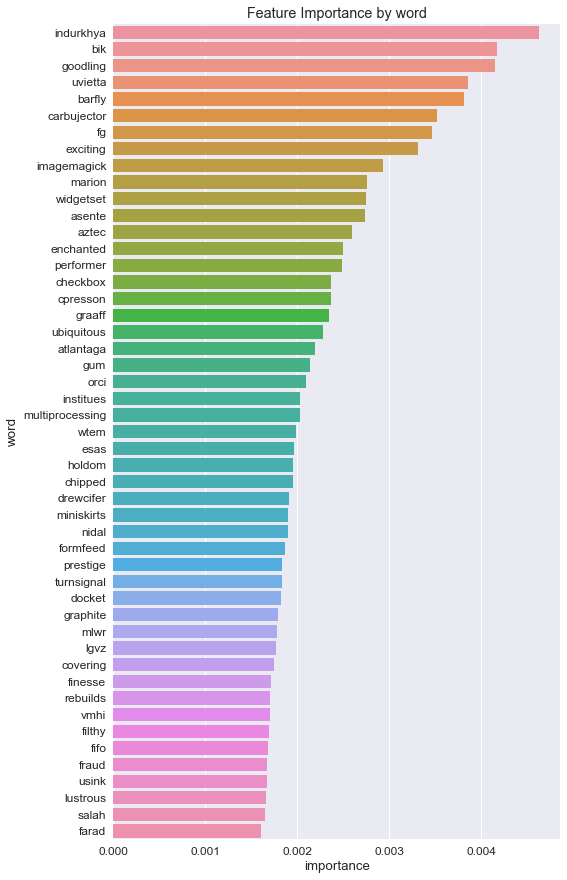

In [23]:
f, ax = plt.subplots(figsize=(8, 15))
ax = sns.barplot(y='word', x='importance', 
                 data=feat_importance[1:50],
                 saturation=0.8)
ax.set_title('Feature Importance by word')
ax;